# 0.0 IMPORTS

In [67]:
import pandas       as pd
import numpy        as np
import seaborn      as sns
import scikitplot   as skplt
import xgboost      as xgb
import warnings
warnings.filterwarnings("ignore")
import random      as rd
import pickle


from scikitplot    import metrics as mt
from sklearn       import metrics as m
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from IPython.core.display     import HTML
from scipy                    import stats         as ss
from sklearn                  import preprocessing as pp
from sklearn                  import model_selection as ms
from sklearn                  import ensemble as en
from sklearn                  import neighbors as nh
from sklearn.ensemble         import RandomForestClassifier
from sklearn                  import linear_model as lm
from sklearn.ensemble         import ExtraTreesClassifier
from lightgbm                 import LGBMClassifier 

## 0.1 Functions

In [66]:
#configurando o notebook

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 9]
    plt.rcParams['font.size'] = 24

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    sns.set()
    
jupyter_settings()

def cramer_v(x, y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 )))


def precision_at_k(data, y, pred, k=20000):
    
    data['response'] = y.copy()
    data['score'] = pred[:, 1].tolist()

    data = data.sort_values('score', ascending=False)
    data = data.reset_index(drop=True)

    data['ranking'] = data.index + 1
    # precision
    data['precision_at_k'] = data['response'].cumsum()/data['ranking']
                            
    return data.loc[k, 'precision_at_k']
                  
def recall_at_k(data, y, pred, k=20000):
    
    data['response'] = y.copy()
    data['score'] = pred[:, 1].tolist()

    data = data.sort_values('score', ascending=False)
    data = data.reset_index(drop=True)
                  
    # create ranking order
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']                  

def metrics_at_k(data, y, pred, model_name, k=20000):
         
    data['response'] = y.copy()
    data['score'] = pred[:, 1].tolist()
    # sort clients by propensity score
    data = data.sort_values('score', ascending=False)
    data = data.reset_index(drop=True)
    # create ranking order
    data['ranking'] = data.index + 1

    # precision
    data['precision_at_k'] = data['response'].cumsum()/data['ranking']
    # recall
    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()
                            
    return pd.DataFrame({'Precision_at_k':data.loc[k, 'precision_at_k'],
                        'Recall_at_k':data.loc[k, 'recall_at_k']}, index=[model_name])

def cross_validation(model_name, model, x, y):
    
    precision_at_k_list = []
    recall_at_k_list = []

    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, test_index in skf.split(x, y):
        
        x_train_cv = x.iloc[train_index]
        y_train_cv = y.iloc[train_index]
        
        x_test_cv = x.iloc[test_index]
        y_test_cv = y.iloc[test_index]
        
        
        model.fit(x_train_cv, y_train_cv)
        pred = model.predict_proba(x_test_cv)
        
        
        precision_at_k_list.append(precision_at_k(x_test_cv, y_test_cv, pred))
        recall_at_k_list.append(recall_at_k(x_test_cv, y_test_cv, pred))
        
    
    precision_at_k_mean, precision_at_k_std = np.round(np.mean(precision_at_k_list),2), np.round(np.std(precision_at_k_list),2)
    recall_at_k_mean, recall_at_k_std = np.round(np.mean(recall_at_k_list),2), np.round(np.std(recall_at_k_list),2)
   
    
    return pd.DataFrame({"Precision_at_k": "{} +/- {}".format(precision_at_k_mean, precision_at_k_std),
                        "Recall_at_k": "{} +/- {}".format(recall_at_k_mean, recall_at_k_std)}, index=[model_name])


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [81]:
df_raw = pd.read_csv('insurance_cross_sell.csv')

# 1.0 DESCRIÇÃO DOS DADOS

In [82]:
df1 = df_raw

## 1.1 Drop Colums

In [84]:
#dropando colunas duplicadas do DF
df1 = df1.drop(columns=['id.1', 'id.2'], axis=1)

## 1.2 Data Dimensions

In [85]:
#verificando tamanho do DF
df1.shape

(381109, 12)

## 1.3 Data Types

In [86]:
#verificando tipos de variáveis
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [87]:
#verificando possibilidade de valores NA
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5 Descriptive Statistical 

### 1.5.1 Numerical Attributes

In [9]:
# Central Tendency - mean, median
# Dispersion - std, min, max, range, skew, kurtosis
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [10]:
#Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [11]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00000,381109.00000,381108.00000,190555.00000,190555.00000,110016.69187,-0.00000,-1.20000
1,age,20.00000,85.00000,65.00000,38.82258,36.00000,15.51159,0.67254,-0.56566
2,region_code,0.00000,52.00000,52.00000,26.38881,28.00000,13.22987,-0.11527,-0.86786
3,policy_sales_channel,1.00000,163.00000,162.00000,112.03429,133.00000,54.20392,-0.90001,-0.97081
4,driving_license,0.00000,1.00000,1.00000,0.99787,1.00000,0.04611,-21.59518,464.35430
5,previously_insured,0.00000,1.00000,1.00000,0.45821,0.00000,0.49825,0.16775,-1.97187
6,annual_premium,2630.00000,540165.00000,537535.00000,30564.38958,31669.00000,17213.13247,1.76609,34.00457
7,vintage,10.00000,299.00000,289.00000,154.34740,154.00000,83.67119,0.00303,-1.20069
8,response,0.00000,1.00000,1.00000,0.12256,0.00000,0.32794,2.30191,3.29879


### 1.5.1 Categorical Attributes

In [12]:
#verificando os atributos categóricos
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

In [13]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


# 2.0  Feature Engineering

In [14]:
df2 = df1

In [15]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'bellow_1_year')

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0 Data Filtering

In [16]:
df3 = df2

# 4.0 EDA

In [17]:
df4 = df3

**Hipothesis List:**

1 - Homens são mais propensos a comprar seguro do carro do que as mulheres

2 - Pessoas acima de 40 anos são mais propensos a comprar o seguro do carro

3 - Pessoas que pagam mais de 50k por ano em seguro saúde são mais propensos a comprar também o seguro do carro

4 - Homens de até 30 anos não tendem a se interessar pelo seguro do carro

5 - Donos de carros cujo a idade do veículo é menor que  1 ano tendem a comprar o seguro de carro

6 - Clientes há mais de 100 dias do seguro saúde tendem a ter interesse no seguro do carro

7 - Homens com mais de 50 anos que nunca tiveram seguro de carro não tendem a ter interesse em adquirir um

8 - Clientes que pagam até 30 mil de seguro saúde por ano não tendem a ter interesse no seguro do carro

## 4.1 Univariate Analysis

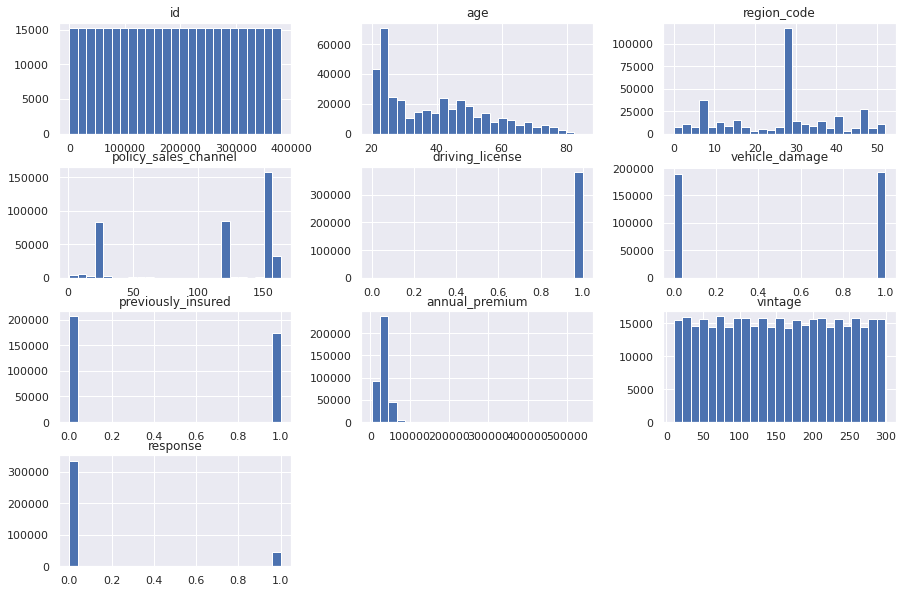

In [18]:
num_attributes = df4.select_dtypes(include=['int64','float64'])
num_attributes.hist(figsize=(15,10), bins=25);

<AxesSubplot:xlabel='response', ylabel='age'>

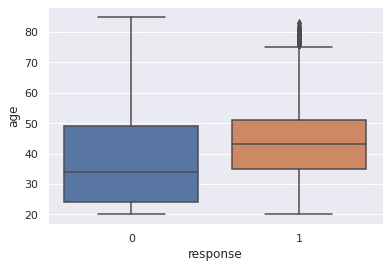

In [19]:
# age
sns.boxplot(x='response', y='age', data=df4)

<AxesSubplot:xlabel='driving_license', ylabel='response'>

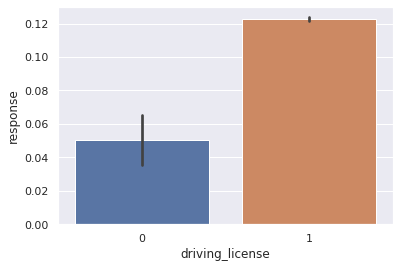

In [20]:
# driving licence
sns.barplot(x='driving_license', y='response', data=df4)

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

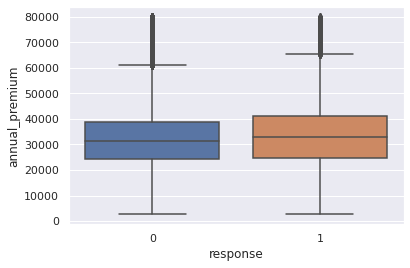

In [21]:
#annual_premium
aux0 = df4[df4['annual_premium'] <= 80000]
sns.boxplot(x='response', y='annual_premium', data=aux0)


<AxesSubplot:xlabel='region_code', ylabel='id'>

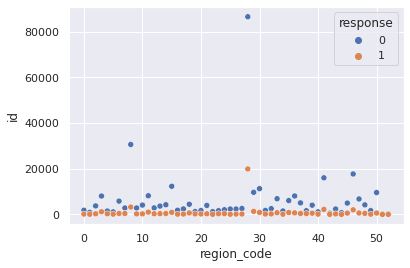

In [22]:
# region_code
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux)

In [23]:
#previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.77455,0.22545
1,0.99910,0.00090


In [24]:
#vehicle age
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.43429
1,bellow_1_year,0,0.41349
2,between_1_2_year,1,0.09133
3,over_2_years,0,0.02966
4,bellow_1_year,1,0.01890
5,over_2_years,1,0.01234


<AxesSubplot:xlabel='response', ylabel='vintage'>

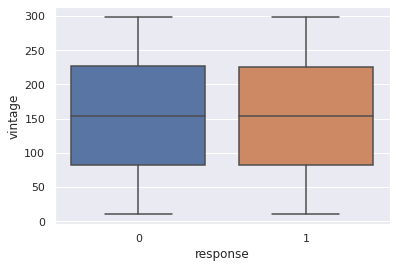

In [25]:
#vintage
sns.boxplot(x='response', y='vintage', data=df4)

## 4.2 Bivariate Analysis

### 1 - Homens são mais propensos a comprar seguro do carro do que as mulheres

***VERDADEIRO*** - conforme gráfico abaixo, homens tendem a se interessar mais pelo seguro do automóvel do que as mulheres

<AxesSubplot:xlabel='gender', ylabel='response'>

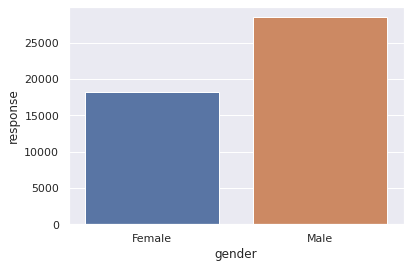

In [26]:
aux1 = df4[df4['response'] == 1]
aux = aux1[['gender', 'response']].groupby('gender').sum().reset_index()
sns.barplot(x='gender', y='response', data=aux)

### 2 - Pessoas acima de 40 anos são mais propensos a comprar o seguro do carro
***VERDADEIRO*** - Conforme gráfico abaixo, pessoas acima de 40 anos são mais propensos a se interessar pelo seguro do carro que menores de 40 anos

<AxesSubplot:xlabel='age', ylabel='response'>

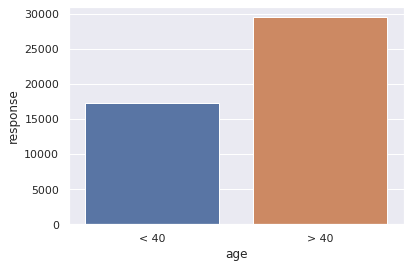

In [27]:
aux1 = df4[df4['response'] == 1]
aux1['age'] = aux1['age'].apply(lambda x: '> 40' if x >= 40 else '< 40')
aux2 = aux1[['age', 'response']].groupby('age').sum().reset_index()
sns.barplot(x='age', y='response', data=aux2)

### 3 - Pessoas que pagam mais de 50k por ano em seguro saúde são mais propensos a comprar também o seguro do carro
***FALSO*** - De acordo com os dados, não temos evidências que pessoas que gastam mais de 50k por ano em seguro saúde tem mais chances de adquirir o seguro do automóvel em relação a quem gasta menos que 50k por ano

<AxesSubplot:xlabel='annual_premium', ylabel='response'>

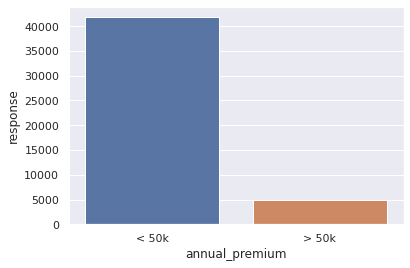

In [28]:
aux = df4[['annual_premium', 'response']][df4['response'] == 1].copy()
aux['annual_premium'] =  aux['annual_premium'].apply(lambda x: '> 50k' if x >= 50000 else '< 50k')
aux1 = aux[['annual_premium', 'response']].groupby('annual_premium').sum().reset_index()
aux1
sns.barplot(x='annual_premium', y='response', data=aux1)

### 4 - Homens de até 30 anos não tendem a se interessar pelo seguro do carro em média
***VERDADEIRO*** - Homens de até 30 anos tem um interesse significativamente menor em adquirir o seguro do carro em comparação a maiores de 30 anos

In [29]:
aux = df4[['age','gender', 'response']][df4['gender'] == 'Male' ][df4['response'] == 1]
aux['age'] = aux['age'].apply(lambda x: '<= 30' if x <= 30 else '> 30')
aux1 = aux[['age', 'response']].groupby('age').sum().reset_index()
aux1

,age,response
0,<= 30,3942
1,> 30,24583


<AxesSubplot:xlabel='age', ylabel='response'>

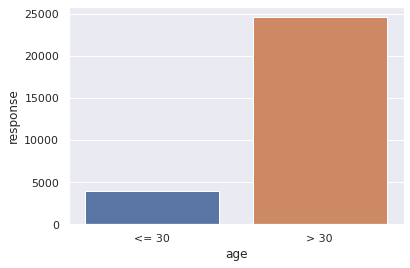

In [30]:
sns.barplot(x='age', y='response', data=aux1)

### 5 - Donos de carros cujo a idade do veículo é menor que  1 ano tendem a comprar o seguro de carro
***FALSO*** - Donos de carros com idade entre 1 e 2 anos tendem a ter mais interesse do que donos de automóveis com idade inferior a 1 ano

In [31]:
aux = df4[['vehicle_age','response']][df4['response'] == 1]
aux1 = aux.groupby('vehicle_age').sum().reset_index()
aux1

,vehicle_age,response
0,bellow_1_year,7202
1,between_1_2_year,34806
2,over_2_years,4702


<AxesSubplot:xlabel='vehicle_age', ylabel='response'>

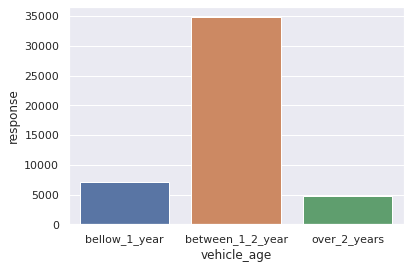

In [32]:
sns.barplot(x='vehicle_age', y='response', data=aux1)

### 6 - Clientes há mais de 100 dias do seguro saúde tendem a ter interesse no seguro do carro
**VERDADEIRO** - Clientes que possuem seguro saúde há mais de 100 dias possuem maior interesse em adquirir o seguro do automóvel

<AxesSubplot:xlabel='vintage', ylabel='response'>

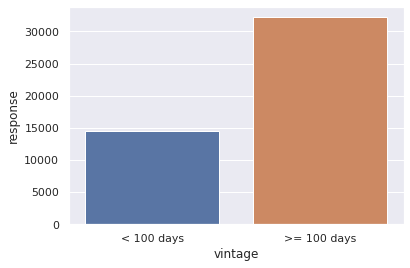

In [33]:
aux = df4[df4['response'] == 1].copy()
aux['vintage'] = df4['vintage'].apply(lambda x: '>= 100 days' if x >= 100 else '< 100 days') 
aux1 = aux[['vintage', 'response']].groupby('vintage').sum().reset_index()
sns.barplot(x='vintage', y='response', data=aux1)

### 7 - Homens com mais de 50 anos que nunca tiveram seguro de carro não tendem a ter interesse
**VERDADEIRO** - Conforme vemos na tabela abaixo, clientes com mais de 50 anos e que nunca tiveram um seguro de carro, não tendem a ter interesse em adquirir o seguro após essa idade

In [34]:
aux = df4.copy()
aux['age'] = aux['age'].apply(lambda x: '>=_50_years' if x >= 50 else '<_50_years')
aux1 = aux[['age', 'response', 'previously_insured']].groupby(['age', 'previously_insured']).count().reset_index()
aux1

,age,previously_insured,response
0,<_50_years,0,142886
1,<_50_years,1,143416
2,>=_50_years,0,63595
3,>=_50_years,1,31212


### 8 - Clientes que pagam até 30 mil de seguro saúde por ano não tendem a ter interesse no seguro do carro
**FALSO** Como percebemos no gráfico abaixo, o valor que se paga no seguro saúde não determina se a pessoa terá interesse ou não em adquirir o seguro do carro

<AxesSubplot:xlabel='annual_premium', ylabel='response'>

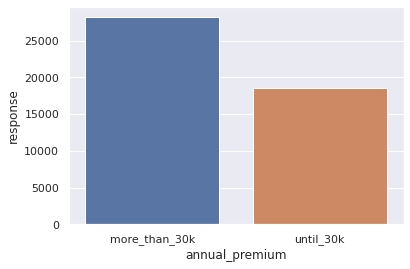

In [35]:
aux = df4[['annual_premium', 'response']][df4['response'] == 1].copy()
aux['annual_premium'] =  aux['annual_premium'].apply(lambda x: 'until_30k' if x <= 30000 else 'more_than_30k')
aux1 = aux[['annual_premium', 'response']].groupby('annual_premium').sum().reset_index()
aux1
sns.barplot(x='annual_premium', y='response', data=aux1)

## 4.3 Analise Multivariada


### 4.3.1 Numerical Attributes 

<AxesSubplot:>

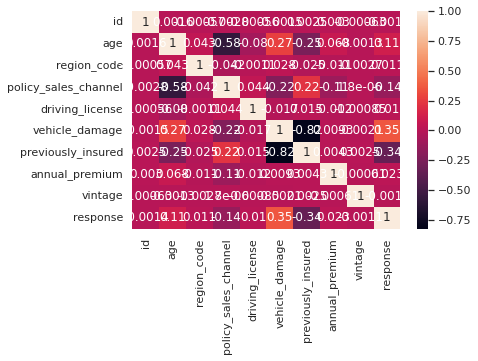

In [36]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.1 Categorical Attributes


In [37]:
a = df4.select_dtypes(include='object')

In [38]:
a.head()

,gender,vehicle_age
0,Male,bellow_1_year
1,Female,between_1_2_year
2,Female,bellow_1_year
3,Female,bellow_1_year
4,Male,between_1_2_year


In [39]:
#utlizando método de cramer para verificar a correlação entre variáveis categóricas

a1 = cramer_v(a['gender'], a['gender'])
a2 = cramer_v(a['gender'], a['vehicle_age'])

a4 = cramer_v(a['vehicle_age'], a['gender'])
a5 = cramer_v(a['vehicle_age'], a['vehicle_age'])


d = pd.DataFrame({'gender': [a1,a2],
              'vehicle_age': [a4,a5]})

d = d.set_index(d.columns)

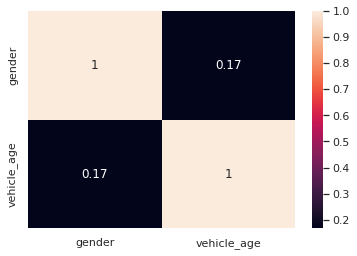

In [40]:
sns.heatmap(d, annot=True);


# 5.0 Data Preparation

In [76]:
df5 = df4.copy()

In [42]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20)

df5 = pd.concat([x_train, y_train], axis=1)

## Standardzation

In [70]:
ssc = pp.StandardScaler()

# annual premium
df5['annual_premium'] = ssc.fit_transform(df5[['annual_premium']].values)
#pickle.dump(ssc, open('parameter/annual_premium.pkl', 'wb'))

## Rescaling

In [71]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
#pickle.dump(mms_age, open('parameter/age.pkl', 'wb'))

# vintage 
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
#pickle.dump(mms_vintage, open('parameter/vintage.pkl', 'wb'))

## Encoder

In [77]:
# gender
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)
#pickle.dump(target_encode_gender, open('parameter/target_encode_gender.pkl', 'wb'))

# region code - Target Encode
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)
#pickle.dump(target_encode_region_code, open('parameter/target_encode_region_code.pkl', 'wb'))

# vehicle_age - One Hot Encoding  
df5 = pd.get_dummies(df5, prefix=['vehicle_age'], columns=['vehicle_age'])

# policy_sales_channel - Frequency Encode
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size()/len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
#pickle.dump(fe_policy_sales_channel, open('parameter/policy_sales_channel.pkl', 'wb'))

## 5.4 Validation Preparation

In [46]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)

# age 
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# region code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
x_validation.loc[:, 'annual_premium'] = ssc.transform(x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

#fillna
x_validation = x_validation.fillna(0)

# 6.0 Feature Selection

## 6.1 Features Importance

In [65]:
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

#data preparation
x_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

KeyboardInterrupt: 

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices =  np.argsort(importances)[::-1]

# print the feature ranking
print("Feature Ranking:")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature':i, 'importance':j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# plot the impurity based feature importance of the forest
plt.figure()
plt.title("Feature Importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0 Machine Learning

In [47]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

x_train = df5[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 7.1 KNN 

In [54]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=8)

# model fit
knn_model.fit(x_train, y_train)

# model predict
yhat_knn = knn_model.predict_proba(x_val)

In [55]:
metrics_knn = metrics_at_k(x_val.copy(), y_validation, yhat_knn, 'KNN')
metrics_knn

,Precision_at_k,Recall_at_k
KNN,0.29274,0.62802


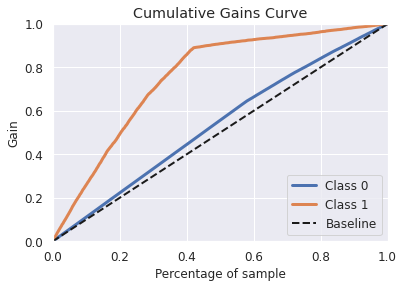

In [56]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

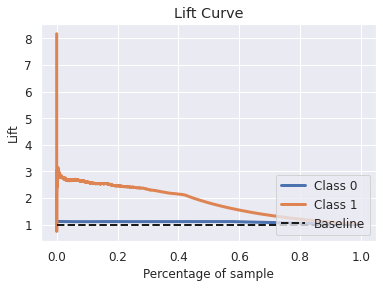

In [57]:
skplt.metrics.plot_lift_curve(y_val, yhat_knn);

## 7.2 Random Forest

In [58]:
# model definition}
rf_model = RandomForestClassifier(n_estimators=1000, n_jobs=-1)

# model fit
rf_model.fit(x_train, y_train)

# model predict
yhat_rf = rf_model.predict_proba(x_val)

In [59]:
metrics_rf = metrics_at_k(x_val.copy(), y_validation, yhat_rf, 'Random Forest')
metrics_rf

,Precision_at_k,Recall_at_k
Random Forest,0.30818,0.66116


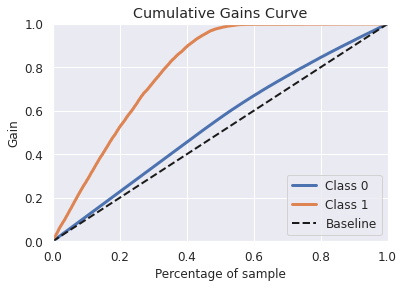

In [60]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

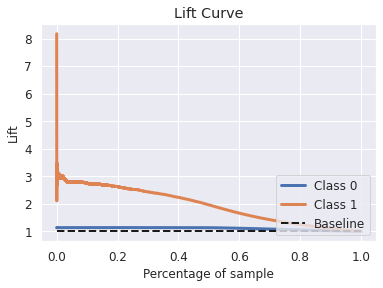

In [61]:
skplt.metrics.plot_lift_curve(y_val, yhat_rf)

## 7.3 Logistic Regression 

In [62]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model fit
lr_model.fit(x_train, y_train)

# model predict
yhat_lr = lr_model.predict_proba(x_val)

In [63]:
metrics_lr = metrics_at_k(x_val.copy(), y_validation, yhat_lr, 'Logistic Regression')
metrics_lr

,Precision_at_k,Recall_at_k
Logistic Regression,0.28554,0.61257


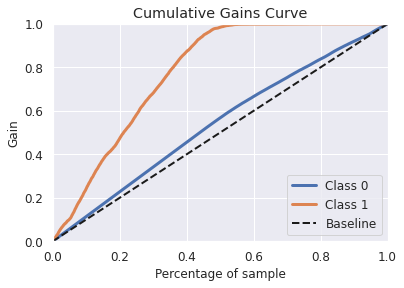

In [64]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

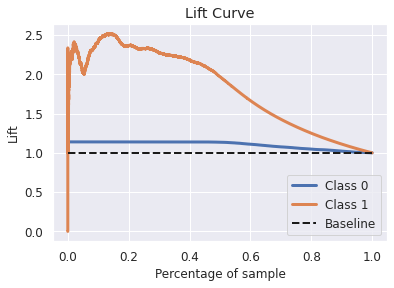

In [65]:
skplt.metrics.plot_lift_curve(y_val, yhat_lr)

## 7.4 XGBoost

In [66]:
# model definition
xgb_model = XGBClassifier(objective='binary:logistic', verbosity=0)

# model fit
xgb_model.fit(x_train, y_train)

# model predict
yhat_xgb = xgb_model.predict_proba(x_val)

In [67]:
metrics_xgb = metrics_at_k(x_val.copy(), y_validation, yhat_xgb, 'XGB')
metrics_xgb

,Precision_at_k,Recall_at_k
XGB,0.32903,0.70589


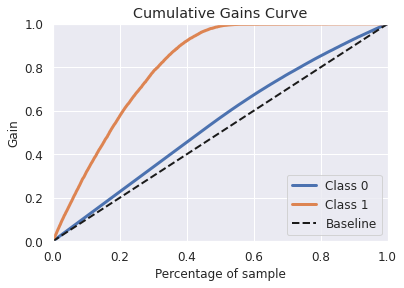

In [68]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb);

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

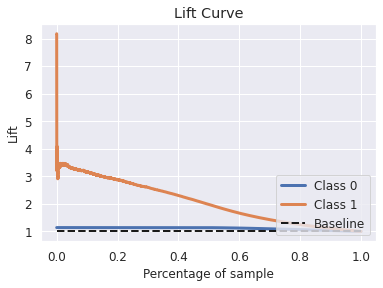

In [69]:
skplt.metrics.plot_lift_curve(y_val, yhat_xgb)

## 7.5 ExtraTrees

In [ ]:
# model definition
extratrees_model = ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

# model fit
extratrees_model.fit(x_train, y_train)

# model predict
yhat_extratrees = extratrees_model.predict_proba(x_val)

In [ ]:
metrics_extratrees = metrics_at_k(x_val.copy(), y_validation, yhat_extratrees, 'ExtraTrees')
metrics_extratrees

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_extratrees);

In [ ]:
skplt.metrics.plot_lift_curve(y_val, yhat_extratrees)

## 7.6 LightGBM

In [48]:
# model definition
lgb = LGBMClassifier(objective='binary', class_weight='balanced')

# model fit
lgb.fit(x_train, y_train)

# model predict
yhat_lgbm = lgb.predict_proba(x_val)

In [49]:
metrics_lgbm = metrics_at_k(x_val.copy(), y_validation, yhat_lgbm, 'LGBM')
metrics_lgbm

,Precision_at_k,Recall_at_k
LGBM,0.33393,0.71243


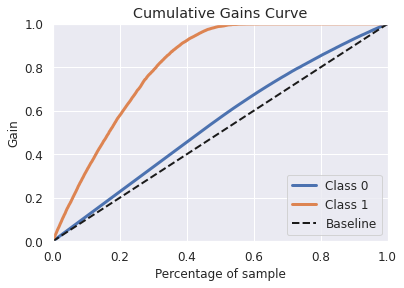

In [50]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm);

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

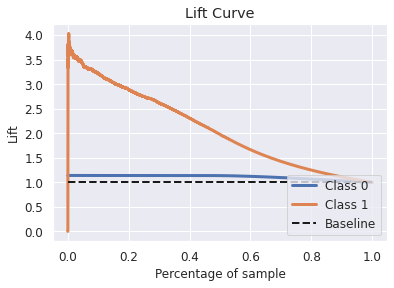

In [51]:
skplt.metrics.plot_lift_curve(y_val, yhat_lgbm)

## 7.7 Model Results

In [ ]:
model_metrics = pd.concat([metrics_knn, metrics_lr, metrics_xgb, metrics_extratrees, metrics_lgbm])
model_metrics.style.highlight_max(color='lightgreen', axis=0)


## 7.8 Cross Validation Model Results

In [ ]:
metrics_cv_knn = cross_validation('KNN', nh.KNeighborsClassifier(), x_train, y_train)
metrics_cv_lr = cross_validation('Logistic Regression', lm.LogisticRegression(), x_train, y_train)
metrics_cv_xgb = cross_validation('XGB', XGBClassifier(), x_train, y_train)
metrics_cv_extratrees = cross_validation('Extra Tress', ExtraTreesClassifier(), x_train, y_train)
metrics_cv_lgbm = cross_validation('LGBM', LGBMClassifier(), x_train, y_train)

In [ ]:
metrics_cv = pd.concat([metrics_cv_knn, metrics_cv_lr, metrics_cv_xgb, metrics_cv_extratrees, metrics_cv_lgbm])
metrics_cv

# 8.0 Hyperparameter Fine Tuning 

## 8.1 LGBM

In [95]:
max_eval = 5

In [96]:
lgbm_parameter = {'num_leaves': (5, 15, 45, 60, 90),
                  'max_depth': (5, 7, 10),
                  'min_split_gain': (0.001, 0.01, 0.1),
                  'min_child_weight': (10, 50, 30, 40),
                  'subsample': (0.5, 1)
                 }

In [97]:
final_result = pd.DataFrame()

In [98]:
for i in range (max_eval):
    #escolher parametro aleatoriamente
    hp = {k: rd.sample(v,1)[0] for k, v in lgbm_parameter.items()}
    print(hp)
    model_lgbm  = LGBMClassifier(num_leaves=hp['num_leaves'],
                                max_depth=hp['max_depth'],
                                min_split_gain=hp['min_split_gain'],
                                min_child_weight=hp['min_child_weight'],
                                subsample=hp['subsample']).fit(x_train, y_train)
    
    yhat_lgbm_hp=model_lgbm.predict_proba(x_val)
    lgbm_result_hp = metrics_at_k(x_val.copy(), y_validation, yhat_lgbm_hp, 'LGBM')
    final_result = pd.concat([final_result, lgbm_result_hp])


{'num_leaves': 60, 'max_depth': 7, 'min_split_gain': 0.001, 'min_child_weight': 50, 'subsample': 0.5}
{'num_leaves': 45, 'max_depth': 5, 'min_split_gain': 0.01, 'min_child_weight': 10, 'subsample': 0.5}
{'num_leaves': 45, 'max_depth': 5, 'min_split_gain': 0.001, 'min_child_weight': 40, 'subsample': 0.5}
{'num_leaves': 15, 'max_depth': 10, 'min_split_gain': 0.1, 'min_child_weight': 30, 'subsample': 1}
{'num_leaves': 90, 'max_depth': 10, 'min_split_gain': 0.1, 'min_child_weight': 30, 'subsample': 1}


In [99]:
final_result

,Precision_at_k,Recall_at_k
LGBM,0.32903,0.71215
LGBM,0.32813,0.71020
LGBM,0.32968,0.71356
LGBM,0.32838,0.71075
LGBM,0.32888,0.71183


## 8.2 XGBoost

In [104]:
max_eval = 5

In [105]:
final_result_xgb = pd.DataFrame()

In [106]:
xgb_parameter = { 'max_depth': (6, 8, 11),
                  'n_estimators': (80, 100, 300, 500, 1000, 2000, 3500),
                  'eta': (1, 2, 3),
                  'subsample': (0.5, 1)
                 }

In [107]:
for i in range (max_eval):
    #escolher parametro aleatoriamente
    hp = {k: rd.sample(v,1)[0] for k, v in xgb_parameter.items()}
    print(hp)
    model_xgb  = XGBClassifier( max_depth=hp['max_depth'],
                                n_estimators=hp['n_estimators'],
                                eta=hp['eta'],
                                subsample=hp['subsample']).fit(x_train, y_train)
    
    yhat_xgb_hp=model_xgb.predict_proba(x_val)
    xgb_result_hp = metrics_at_k(x_val.copy(), y_validation, yhat_xgb_hp, 'XGB')
    final_result_xgb = pd.concat([final_result, lgbm_result_hp])


{'max_depth': 6, 'n_estimators': 100, 'eta': 3, 'subsample': 0.5}
{'max_depth': 6, 'n_estimators': 500, 'eta': 3, 'subsample': 1}
{'max_depth': 11, 'n_estimators': 80, 'eta': 3, 'subsample': 1}
{'max_depth': 8, 'n_estimators': 500, 'eta': 3, 'subsample': 0.5}
{'max_depth': 11, 'n_estimators': 2000, 'eta': 2, 'subsample': 1}


In [108]:
final_result_xgb

,Precision_at_k,Recall_at_k
LGBM,0.32888,0.71183
LGBM,0.32888,0.71183
LGBM,0.32888,0.71183
LGBM,0.32888,0.71183
LGBM,0.32888,0.71183


Podemos verificar que não houve ganho de perfomance em nenhum dos modelos com o fine tunning, continuaremos com o LGBM por ter o melhor resultado, e ser um modelo leve.

# 9.0 Conclusão

## 9.1 Final Model

In [48]:
best_params_lgbm = {'num_leaves': 90,
                  'max_depth': 10,
                  'min_split_gain': 0.1,
                  'min_child_weight': 30,
                  'subsample': 1
                 }

In [49]:
lgbm_hp = LGBMClassifier(num_leaves=best_params_lgbm['num_leaves'],
                         max_depth=best_params_lgbm['max_depth'],
                         min_split_gain=best_params_lgbm['min_split_gain'],
                         min_child_weight=best_params_lgbm['min_child_weight'],
                         subsample=best_params_lgbm['subsample']).fit(x_train, y_train)

# model predict
yhat_lgbm_hp = lgbm_hp.predict_proba(x_val)

In [50]:
metrics_lgbm_hp = metrics_at_k(x_val.copy(), y_validation, yhat_lgbm_hp, 'LGBM')
metrics_lgbm_hp

,Precision_at_k,Recall_at_k
LGBM,0.33373,0.71574


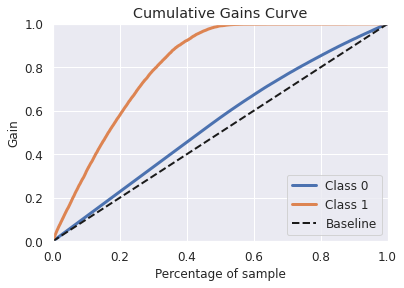

In [51]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm_hp);

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

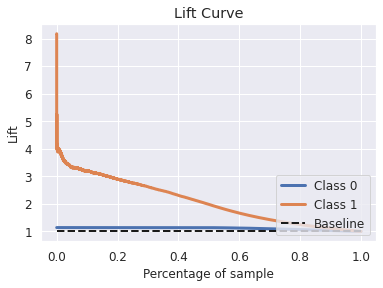

In [52]:
# lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_lgbm_hp)

## 9.2 Perguntas de Negócios

### 9.2.1 Principais Insights Obtidos no Projeto

1. Homens são mais propensos a comprar seguro do carro do que as mulheres.
2. Pessoas acima de 40 anos são mais propensos a comprar o seguro do carro.
3. Clientes há mais de 100 dias do seguro saúde tendem a ter interesse no seguro do carro.

### 9.2.2 Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar realizando 20.000 ligações?

<Figure size 936x576 with 0 Axes>

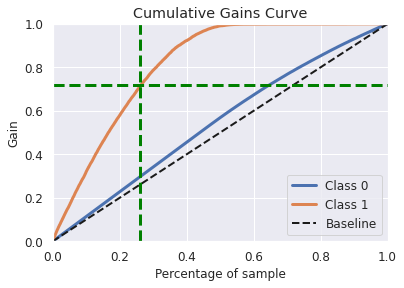

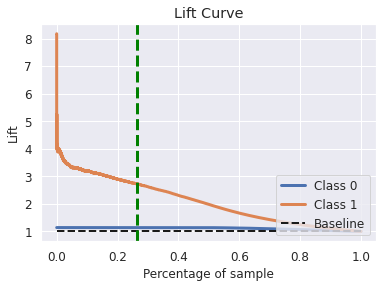

In [61]:
plt.figure(figsize=(13,8))


skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm_hp);
plt.axvline(0.26, 0, 1, color='green', ls='--', lw=3);
plt.axhline(0.72, 0, 1, color='green', ls='--', lw=3);

skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm_hp);
plt.axvline(0.2634, 0, 1, color='green', ls='--', lw=3);

Ao realizar 20 mil ligações, o que representa cerca de 25% da base de clientes, conseguiremos contactar cerca de 70% de clientes interessados em adquirir o seguro para o automóvel.

Ao observarmos a curva lift, observamos que nosso modelo é 2.6x melhor que fazer o trabalho manual de prospecção e oferta ao cliente ao realizar essas 20 mil ligações.

### 9.2.2 Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar realizando 30.000 ligações?

<Figure size 936x576 with 0 Axes>

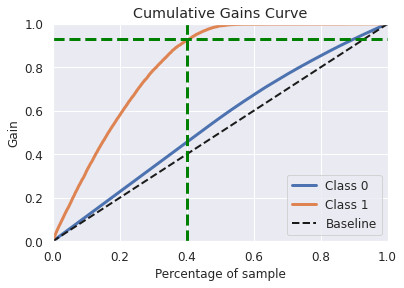

In [65]:
plt.figure(figsize=(13,8))

skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm_hp);
plt.axvline(0.40, 0, 1, color='green', ls='--', lw=3);
plt.axhline(0.93, 0, 1, color='green', ls='--', lw=3);

Ao fazer 30 mil ligações, o que representa cerca de 40% da base, conseguiremos atingir 93% de todos os clientes interessados

# 10.0 Deploy

In [69]:
# model trained
pickle.dump(lgbm_hp, open('parameter/lgbm_hp.pkl', 'wb'))

## 10.1 Health Insurance Class

In [89]:
class HealthInsurance:
    def __init__(self):
        self.home_path                        = '/home/lucas-gonzaga/Documentos/repos/pa004/'
        self.annual_premium_scaler            = pickle.load( open( self.home_path + 'parameter/annual_premium.pkl'))
        self.age_scaler                       = pickle.load( open( self.home_path + 'parameter/age.pkl'))
        self.vintage_scaler                   = pickle.load( open( self.home_path + 'parameter/vintage.pkl'))
        self.target_encode_gender_scaler      = pickle.load( open( self.home_path + 'parameter/target_encode_gender.pkl'))
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'parameter/target_encode_region_code.pkl'))
        self.fe_policy_sales_channel_scaler   = pickle.load( open( self.home_path + 'parameter/policy_sales_channel.pkl'))
    
    def feature_engineering(data):
        # vehicle age
        data['vehicle_age'] = data['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'bellow_1_year')

        # vehicle damage
        data['vehicle_damage'] = data['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        
        return data
    
    def data_preparation(data):

        # annual premium
        data['annual_premium'] = self.annual_premium_scaler.transform(data[['annual_premium']].values)
        
        # age
        data['age'] = self.age_scaler.transform(data[['age']].values)

        # vintage 
        data['vintage'] = self.vintage_scaler.transform(data[['vintage']].values)

        # gender
        data.loc[:, 'gender'] = data['gender'].map(self.target_encode_gender_scaler)

        # region code - Target Encode
        data.loc[:, 'region_code'] = data['region_code'].map(self.target_encode_region_code_scaler)

        # vehicle_age - One Hot Encoding  
        data = pd.get_dummies(data, prefix=['vehicle_age'], columns=['vehicle_age'])
        
        # policy_sales_channel - Frequency Encode
        data.loc[:, 'policy_sales_channel'] = data['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)

        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

        return data[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # model prediction
        pred = model.predict_proba(test_data)
        
        #join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json(orient='record', date_format='iso')